In [1]:
from collections import OrderedDict
from copy import copy
import single_sided_network
import qdyn_model
from notebook_plots import display_hamiltonian
from sympy import Symbol
import QDYN
from QDYN.pulse import blackman
from QDYN.shutil import mkdir
import matplotlib.pylab as plt
import numpy as np
import sympy
from sympy import pi

In [2]:
%load_ext autoreload
%autoreload 2

## Circuit

### 3 Nodes

In [3]:
circuit3 = single_sided_network.network_circuit(n_nodes=3, topology='bs_fb')

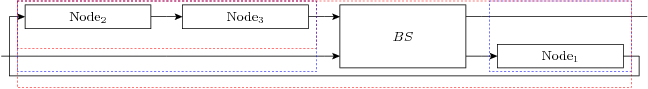

In [4]:
circuit3.show()

In [30]:
slh3 = single_sided_network.network_slh(n_cavity=2, n_nodes=3, topology='bs_fb')

In [6]:
slh3.S

[[1]]

In [7]:
slh3.L

[[-sqrt(2)*sqrt(κ)*cos(θ)/(sin(θ) - 1) * â^(c₁) - sqrt(2)*sqrt(κ)*cos(θ)/(sin(θ) - 1) * â^(c₂) - sqrt(2)*sqrt(κ)*cos(θ)/(sin(θ) - 1) * â^(c₃)]]

In [8]:
display_hamiltonian(slh3.H)

<IPython.core.display.Latex object>

### 4 Nodes

In [38]:
slh4 = single_sided_network.network_slh(n_cavity=2, n_nodes=4, topology='bs_fb')

In [39]:
display_hamiltonian(slh4.H)

<IPython.core.display.Latex object>

### 5 Nodes

In [45]:
slh5 = single_sided_network.network_slh(n_cavity=2, n_nodes=5, topology='bs_fb')

In [46]:
display_hamiltonian(slh5.H)

<IPython.core.display.Latex object>

## Numerical Values (3 Nodes)

In [9]:
controls3 = sorted([sym for sym in slh3.H.all_symbols() if sym.name.startswith('Omega')], key=str)

In [10]:
# from algebra import generate_num_vals_code
# generate_num_vals_code(slh.all_symbols())

In [11]:
Delta =  5000.0  # MHz
g     =    50.0  # MHz
kappa =     0.5  # MHz
E0    =    70.0  # MHz
t0    = -4    # microsec
T     =  4    # microsec
nt    = 2001
theta = 1.5 * np.pi
num_vals3 = {
    Symbol('Delta_1', real=True):   Delta,
    Symbol('Delta_2', real=True):   Delta,
    Symbol('Delta_3', real=True):   Delta,
    Symbol('g_1', positive=True):   g,
    Symbol('g_2', positive=True):   g,
    Symbol('g_3', positive=True):   g,
    Symbol('kappa', positive=True): kappa,
    Symbol('theta', real=True):     theta,
}

## Magnitude of coefficients

In [12]:
from qnet.algebra.pattern_matching import pattern
from qnet.algebra.operator_algebra import ScalarTimesOperator

In [13]:
{str(t.coeff): t.coeff.subs(num_vals3) for t in pattern(head=ScalarTimesOperator).findall(slh3.H)}

{'-I*Omega_1*g_1/(2*Delta_1)': -0.005*I*Omega_1,
 '-I*Omega_2*g_2/(2*Delta_2)': -0.005*I*Omega_2,
 '-I*Omega_3*g_3/(2*Delta_3)': -0.005*I*Omega_3,
 '-I*kappa': -0.5*I,
 '-g_1**2/Delta_1': -0.500000000000000,
 '-g_2**2/Delta_2': -0.500000000000000,
 '-g_3**2/Delta_3': -0.500000000000000,
 'I*Omega_1*g_1/(2*Delta_1)': 0.005*I*Omega_1,
 'I*Omega_2*g_2/(2*Delta_2)': 0.005*I*Omega_2,
 'I*Omega_3*g_3/(2*Delta_3)': 0.005*I*Omega_3,
 'I*kappa': 0.5*I,
 'g_1**2/Delta_1': 0.500000000000000,
 'g_2**2/Delta_2': 0.500000000000000,
 'g_3**2/Delta_3': 0.500000000000000}

## Time Grid and Guess Pulse

In [14]:
tgrid = QDYN.pulse.pulse_tgrid(t0=t0, T=T, nt=nt) # microsec

In [15]:
p = QDYN.pulse.Pulse(
    tgrid, amplitude=(E0 * blackman(tgrid, t0, T)),
    time_unit='microsec', ampl_unit='MHz')

In [16]:
controls3 = OrderedDict([
    (Symbol('Omega_1'), p.copy()),
    (Symbol('Omega_2'), p.copy()),
    (Symbol('Omega_3'), p.copy()),
])

##  OCT for sqrtSWAP (hs)

In [17]:
sqrt_SWAP = QDYN.gate2q.Gate2Q([
    [1,             0,             0,   0],
    [0, -1/np.sqrt(2),  1/np.sqrt(2),   0],
    [0, -1/np.sqrt(2), -1/np.sqrt(2),   0],
    [0,             0,             0, -1j]]
)

In [18]:
model = qdyn_model.make_qdyn_oct_model(
    slh3, num_vals3, controls3, energy_unit='MHz',
    mcwf=False, non_herm=True, oct_target='gate',
    lambda_a=1e-4)

In [19]:
model.write_to_runfolder("./BS_FB/sqrtSWAP3_oct_hs001/")
sqrt_SWAP.write("./BS_FB/sqrtSWAP3_oct_hs001/target_gate.dat")

##  OCT for Dicke State (3 nodes, hs)

In [31]:
num_vals_diss3 = num_vals3.copy()
θ = Symbol('theta', real=True)
num_vals_diss3[θ] = 0.25 * np.pi

In [34]:
model = qdyn_model.make_qdyn_oct_model(
    slh3, num_vals_diss3, controls3, energy_unit='MHz',
    mcwf=True, non_herm=True, oct_target='dicke',
    lambda_a=1e-1)

In [35]:
model.write_to_runfolder("./BS_FB/dicke3_oct_hs001/")

##  OCT for Dicke State (4 nodes, hs)

In [41]:
num_vals4 = {
    Symbol('Delta_1', real=True):   Delta,
    Symbol('Delta_2', real=True):   Delta,
    Symbol('Delta_3', real=True):   Delta,
    Symbol('Delta_4', real=True):   Delta,
    Symbol('g_1', positive=True):   g,
    Symbol('g_2', positive=True):   g,
    Symbol('g_3', positive=True):   g,
    Symbol('g_4', positive=True):   g,
    Symbol('kappa', positive=True): kappa,
    Symbol('theta', real=True):     0.25 * np.pi,
}

In [42]:
controls4 = OrderedDict([
    (Symbol('Omega_1'), p.copy()),
    (Symbol('Omega_2'), p.copy()),
    (Symbol('Omega_3'), p.copy()),
    (Symbol('Omega_4'), p.copy()),
])

In [43]:
model = qdyn_model.make_qdyn_oct_model(
    slh4, num_vals4, controls4, energy_unit='MHz',
    mcwf=True, non_herm=True, oct_target='dicke',
    lambda_a=1e-1)

In [44]:
model.write_to_runfolder("./BS_FB/dicke4_oct_hs001/")

##  OCT for Dicke State (5 nodes, hs)

In [47]:
num_vals5 = {
    Symbol('Delta_1', real=True):   Delta,
    Symbol('Delta_2', real=True):   Delta,
    Symbol('Delta_3', real=True):   Delta,
    Symbol('Delta_4', real=True):   Delta,
    Symbol('Delta_5', real=True):   Delta,
    Symbol('g_1', positive=True):   g,
    Symbol('g_2', positive=True):   g,
    Symbol('g_3', positive=True):   g,
    Symbol('g_4', positive=True):   g,
    Symbol('g_5', positive=True):   g,
    Symbol('kappa', positive=True): kappa,
    Symbol('theta', real=True):     0.25 * np.pi,
}

In [48]:
controls5 = OrderedDict([
    (Symbol('Omega_1'), p.copy()),
    (Symbol('Omega_2'), p.copy()),
    (Symbol('Omega_3'), p.copy()),
    (Symbol('Omega_4'), p.copy()),
    (Symbol('Omega_5'), p.copy()),
])

In [49]:
model = qdyn_model.make_qdyn_oct_model(
    slh5, num_vals5, controls5, energy_unit='MHz',
    mcwf=True, non_herm=True, oct_target='dicke',
    lambda_a=1e-1)

In [50]:
model.write_to_runfolder("./BS_FB/dicke5_oct_hs001/")

## Example optimization commands

*   hilbert space optimization

    ```OMP_NUM_THREADS=1 qdyn_optimize --internal-units=GHz_units.txt --debug --J_T=J_T_re .```

*   trajectory optimization (model with `mcwf=True`)

    ```OMP_NUM_THREADS=1 qdyn_optimize --internal-units=GHz_units.txt --n-trajs=20 --J_T=J_T_sm .```